In [64]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from datetime import datetime, timedelta

# 주식데이터 불러오기

### 종목코드와 링크 생성

In [65]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

In [66]:
#상장된 기업들목록에서 회사명과 종목코드만 가져옴
code_df = code_df[['회사명', '종목코드']]
code_df = code_df.rename(columns={'회사명':'name', '종목코드':'code'})
code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355 entries, 0 to 2354
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2355 non-null   object
 1   code    2355 non-null   object
dtypes: object(2)
memory usage: 36.9+ KB


In [67]:
#회사명을 넣으면, code_df를 뒤져서 종목코드를 찾고, 네이버주식url에 덧대서 출력해주는 함수
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    code = code[1:7]
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)
    print("요청 URL = {}".format(url))
    return url

item_name = '엔씨소프트'
url = get_url(item_name, code_df)

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=036570


### 날짜별 종가, 전일비, 시가, 고가, 저가, 거래량 불러오기

In [68]:
def convert_col_name_kor_eng(df):  
    df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
    df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['date'], ascending=True) 
    df.head()
    return df

def get_dataset(num_date):
    df = pd.DataFrame()
    for page in range(1,num_date+1):
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    df = df.dropna()
    df = convert_col_name_kor_eng(df)
    return df

df = get_dataset(493)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4928 entries, 7392 to 1
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4928 non-null   datetime64[ns]
 1   close   4928 non-null   int64         
 2   diff    4928 non-null   int64         
 3   open    4928 non-null   int64         
 4   high    4928 non-null   int64         
 5   low     4928 non-null   int64         
 6   volume  4928 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 308.0 KB


### 데이터프레임 -> 넘파이

In [70]:
df = df.drop(['date'], axis=1)
df_size = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4928 entries, 7392 to 1
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   4928 non-null   int64
 1   diff    4928 non-null   int64
 2   open    4928 non-null   int64
 3   high    4928 non-null   int64
 4   low     4928 non-null   int64
 5   volume  4928 non-null   int64
dtypes: int64(6)
memory usage: 269.5 KB


In [71]:
print(df_size)

4928


In [72]:
train_set = df[0:int(df_size*0.7)]
test_set = df[int(df_size*0.7):]

In [73]:
train = train_set.to_numpy()
test = test_set.to_numpy()

In [74]:
print(train.shape)
print(test.shape)
print(train[1])
print(train[2])

(3449, 6)
(1479, 6)
[87800  9400 87800 87800 87800   206]
[98300 10500 98300 98300 98300 92439]


# 데이터 전처리

#### minmax정규화, RNN용 shape으로 변경

In [75]:
def minmax_scaler(data):
    #print(np.min(data,0))
    numerator = data - np.min(data,0)
    #print(numerator.shape)
    denominator = np.max(data,0) - np.min(data,0)
    #print(numerator.shape)
    return numerator / (denominator + 1e-7)

def build_dataset(time_series, seq_length):
    train_size = int(len(time_series - seq_length))
    dataX = []
    dataY = []

    for i in range(0, len(time_series)-seq_length-1):
        _x = time_series[i:i + seq_length,2]
        _y = time_series[i + seq_length + 1,[0]]
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)
#2차원 배열 -> 넘파이배열로 변경시 자료의 사이즈가 맞지 않으면 object타입으로 처리해서 3차원배열로 인식하지 않는다.

In [76]:
train = minmax_scaler(train)
test_min = np.min(test, 0)
test_max = np.max(test, 0)
test_denom = test_max - test_min
test_minmax = (test-test_min) / (test_denom + 1e-7)#minmax_scaler(test) 

print(train_set.shape)
print(test_set.shape)

(3449, 6)
(1479, 6)


In [77]:
train[:,2].shape

(3449,)

In [78]:
train[:,2]

array([0.1547286 , 0.18102966, 0.21040851, ..., 0.43480694, 0.43900392,
       0.423615  ])

In [79]:
test_minmax.shape

(1479, 6)

In [80]:
seq_length = 7

In [81]:
trainX, trainY = build_dataset(train, seq_length)
testX, testY = build_dataset(test_minmax, seq_length)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(3441, 7) (3441, 1)
(1471, 7) (1471, 1)


In [82]:
trainX = trainX.reshape(-1, 7, 1)
testX = testX.reshape(-1, 7, 1)
print(trainX.shape)
print(testX.shape)

(3441, 7, 1)
(1471, 7, 1)


### 넘파이 -> 텐서

In [83]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target

    def __len__(self):
        return len(self.samples)

In [84]:
def load(batch_size):
    transform = None
    train_set = data_loader(trainX, trainY, transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_set = data_loader(testX, testY, transform)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 데이터 출력용 함수들

In [86]:
def show_train_status(): #학습한 loss 출력
    plt.plot(loss_arr)
    plt.show()
    print(model)
    print(loss_func)
    print(optimizer)
    print('----------------------')
    print('batch_size : ',batch_size)
    print('epoch : ',epoch)

#### 1. 시가->예측종가기준으로 평가

In [87]:
def eval_open_to_predict_close(day):    
    day_length = len(predicted_y)
    money = 0
    count_acc = 0
    count_i = 0

    for i in range(day_length-day, day_length):
        count_i = count_i + 1
        #당일 날짜 계산
        today = datetime.today() - timedelta(days=day_length) + timedelta(days=i)
        str_year  = today.strftime('%Y')[:2]
        str_today = str_year + today.strftime('-%m-%d')
        # 투자하면 벌돈 및 실제 벌돈 계산
        expect_money = calculated_predicted_y[i] - calculated_test_x[i]
        earn_money = calculated_test_y[i] - calculated_test_x[i]
        #print(str_today, '시작가\t','\t', '종가\t', '\t', '수익예상')
        #print('예상가\t', calculated_test_x[i],'\t', calculated_predicted_y[i], '\t',expect_money)
        #print('현실가\t', calculated_test_x[i],'\t', calculated_test_y[i], '\t', earn_money)
        # 수익예상이면 투자후 금액 출력
        if (expect_money > 0):
            money = money + earn_money
        #print('번돈\t', money)
        #print('-----------------------------------------------------')
        # 수익 예측을 정확이 했는지 판단.
        if (expect_money >0) & (earn_money >0): count_acc = count_acc + 1
        if (expect_money <0) & (earn_money <0): count_acc = count_acc + 1
    print('----------------------')
    print('시가->예측종가기준')
    print('벌어들인돈 : {0:d}원'.format(int(money)))
    print('정확도 : {0:.3f}%'.format(count_acc/count_i))

##### 2.전날예측종가->예측종가기준으로 평가

In [88]:
def eval_endPredict_to_predict_close(day):    
    day_length = len(predicted_y)
    money = 0
    count_acc = 0
    count_i = 0

    for i in range(day_length-day, day_length-1):
        count_i = count_i + 1
        #당일 날짜 계산
        today = datetime.today() - timedelta(days=day_length) + timedelta(days=i+1)
        str_year  = today.strftime('%Y')[:2]
        str_today = str_year + today.strftime('-%m-%d')
        # 투자하면 벌돈 및 실제 벌돈 계산
        expect_money = calculated_predicted_y[i+1] - calculated_predicted_y[i]
        earn_money = calculated_test_y[i+1] - calculated_test_y[i]
        #print(str_today, '시작가\t','\t', '종가\t', '\t', '수익예상')
        #print('예상가\t', calculated_predicted_y[i],'\t', calculated_predicted_y[i+1], '\t',expect_money)
        #print('현실가\t',calculated_test_y[i],'\t', calculated_test_y[i+1], '\t', earn_money)
        # 수익예상이면 투자후 금액 출력
        if (expect_money > 0):
            money = money + earn_money
        #print('번돈\t', money)
        #print('-----------------------------------------------------')
        # 수익 예측을 정확이 했는지 판단.
        if (expect_money >0) & (earn_money >0): count_acc = count_acc + 1
        if (expect_money <0) & (earn_money <0): count_acc = count_acc + 1
    print('----------------------')
    print('전날예측종가->예측종가')
    print('벌어들인돈 : {0:d}원'.format(int(money)))
    print('정확도 : {0:.3f}%'.format(count_acc/count_i))

In [89]:
def show_test_graph(day): #환산된 결과 test 그래프
    plt.figure(figsize=(10,5))
    s = len(calculated_predicted_y)
    plt.plot(calculated_predicted_y[s-day:s])
    plt.plot(calculated_test_y[s-day:s])
    plt.legend(['predicted', 'test_y'])
    plt.grid(True)
    plt.xticks([i for i in range(0,day)])
    plt.show()

# 0.학습 모델 --------------------------------------------

In [102]:
data_dim = 1
hidden_dim = 10
output_dim = 1

epoch = 200
lr = 0.001
batch_size=2048
layers=1

train_loader, test_loader= load(batch_size=batch_size)
day = 30

In [103]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, output_dim)#, bias=True)
        )
    def forward(self, x):
        x, _status  = self.rnn(x)
        x = self.fc(x[:,-1])
        return x
              
model = Net(data_dim, hidden_dim, output_dim, layers).to(device)
loss_func = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, threshold=1, patience=1, mode='min')

loss_arr = []
for i in range(epoch):
    for j, [x, y] in enumerate(train_loader):
        train_x = x.to(device).float()
        train_y = y.to(device).float()
        optimizer.zero_grad()
        outputs = model.forward(train_x)
        
        #print(outputs.shape, train_y.shape)
        #print(outputs.dtype, train_y.dtype)
        
        loss = loss_func(outputs, train_y)
        #이걸 변수명을 같게하면 안되지!
        loss.backward()
        optimizer.step()
        loss_arr.append(loss)
    print(i, loss)

0 tensor(0.2999, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.2905, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.2867, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.2820, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.2794, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.2732, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.2711, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.2659, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.2713, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.2566, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.2628, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.2468, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.2491, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.2376, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.2412, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.2404, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.2419, 

136 tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward>)
137 tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward>)
138 tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward>)
139 tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward>)
140 tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward>)
141 tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward>)
142 tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward>)
143 tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward>)
144 tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward>)
145 tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward>)
146 tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward>)
147 tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward>)
148 tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward>)
149 tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward>)
150 tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward>)
151 tensor(0.0247, device='cuda:0', grad_fn=<MseLossBac

# 1.모델 테스트

In [104]:
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)
loss_ar = []

model.eval()
with torch.no_grad():
    for j, [x, y] in enumerate(test_loader):
        #test_x = x.to(device).float()
        #test_y = y.to(device).float()
        test_x = testX_tensor.to(device).float()
        test_y = testY_tensor.to(device).float()
        predicted = model.forward(test_x)
        loss = loss_func(predicted, test_y)
        
        loss_ar.append(loss)

# 2.수익

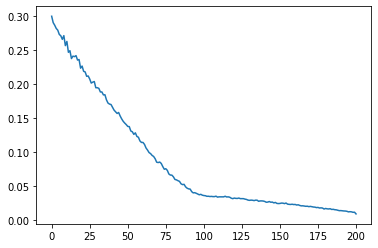

Net(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
----------------------
batch_size :  2048
epoch :  200
----------------------
시가->예측종가기준
벌어들인돈 : 0원
정확도 : 0.367%
----------------------
전날예측종가->예측종가
벌어들인돈 : 187000원
정확도 : 0.552%


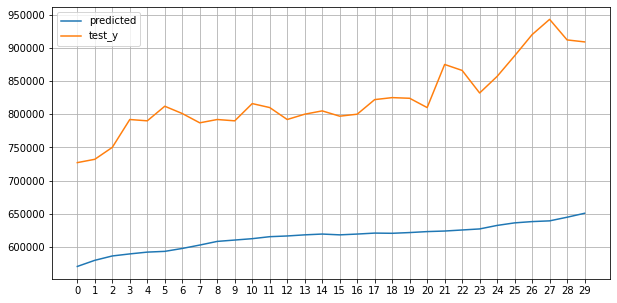

In [106]:
predicted_y = predicted.cpu().numpy()
test_y = testY_tensor.numpy()
test_x = test[7:,2]
calculated_predicted_y = ((predicted_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_y = ((test_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_x = test_x.astype('int')

show_train_status()
eval_open_to_predict_close(day)
eval_endPredict_to_predict_close(day)
show_test_graph(day)

# 3.Result

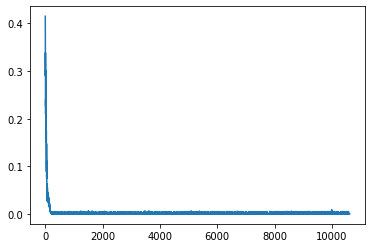

Net(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
----------------------
batch_size :  64
epoch :  200
----------------------
시가->예측종가기준
벌어들인돈 : 204000원
정확도 : 0.567%
----------------------
전날예측종가->예측종가
벌어들인돈 : -57000원
정확도 : 0.310%


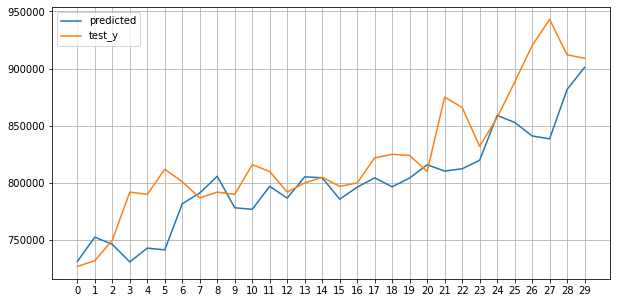

In [32]:
predicted_y = predicted.cpu().numpy()
test_y = testY_tensor.numpy()
test_x = test[7:,2]
calculated_predicted_y = ((predicted_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_y = ((test_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_x = test_x.astype('int')

show_train_status()
eval_open_to_predict_close(day)
eval_endPredict_to_predict_close(day)
show_test_graph(day)

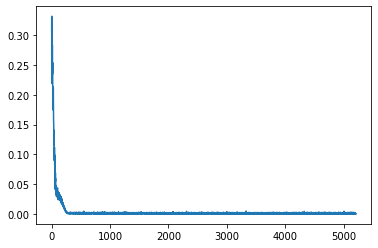

Net(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
----------------------
batch_size :  128
epoch :  200
----------------------
시가->예측종가기준
벌어들인돈 : 199000원
정확도 : 0.567%
----------------------
전날예측종가->예측종가
벌어들인돈 : 62000원
정확도 : 0.448%


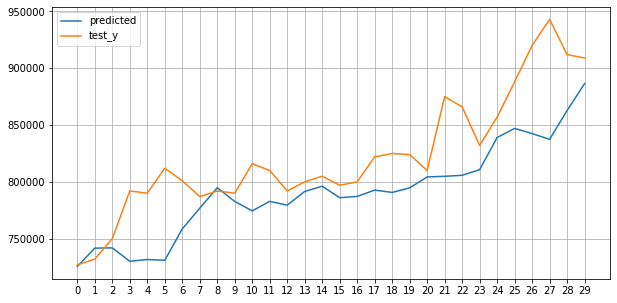

In [62]:
predicted_y = predicted.cpu().numpy()
test_y = testY_tensor.numpy()
test_x = test[7:,2]
calculated_predicted_y = ((predicted_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_y = ((test_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_x = test_x.astype('int')

show_train_status()
eval_open_to_predict_close(day)
eval_endPredict_to_predict_close(day)
show_test_graph(day)

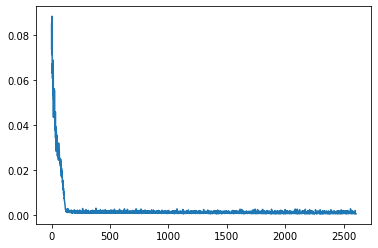

Net(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
----------------------
batch_size :  256
epoch :  200
----------------------
시가->예측종가기준
벌어들인돈 : 223000원
정확도 : 0.600%
----------------------
전날예측종가->예측종가
벌어들인돈 : 96000원
정확도 : 0.517%


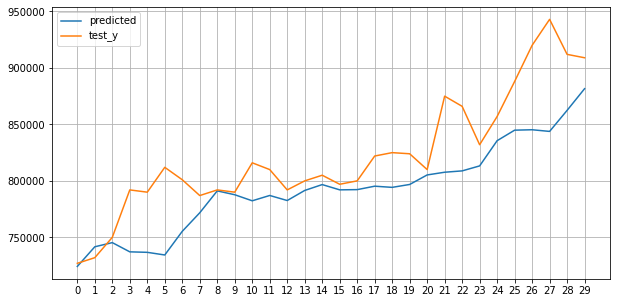

In [93]:
predicted_y = predicted.cpu().numpy()
test_y = testY_tensor.numpy()
test_x = test[7:,2]
calculated_predicted_y = ((predicted_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_y = ((test_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_x = test_x.astype('int')

show_train_status()
eval_open_to_predict_close(day)
eval_endPredict_to_predict_close(day)
show_test_graph(day)

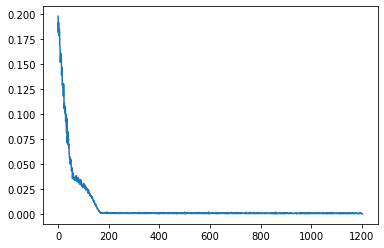

Net(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
----------------------
batch_size :  512
epoch :  200
----------------------
시가->예측종가기준
벌어들인돈 : 22000원
정확도 : 0.400%
----------------------
전날예측종가->예측종가
벌어들인돈 : 187000원
정확도 : 0.552%


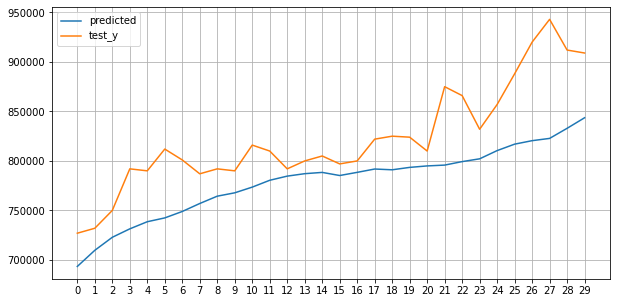

In [97]:
predicted_y = predicted.cpu().numpy()
test_y = testY_tensor.numpy()
test_x = test[7:,2]
calculated_predicted_y = ((predicted_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_y = ((test_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_x = test_x.astype('int')

show_train_status()
eval_open_to_predict_close(day)
eval_endPredict_to_predict_close(day)
show_test_graph(day)

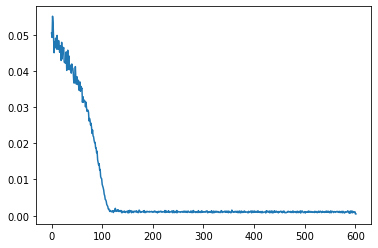

Net(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
----------------------
batch_size :  1024
epoch :  200
----------------------
시가->예측종가기준
벌어들인돈 : 45000원
정확도 : 0.433%
----------------------
전날예측종가->예측종가
벌어들인돈 : 187000원
정확도 : 0.552%


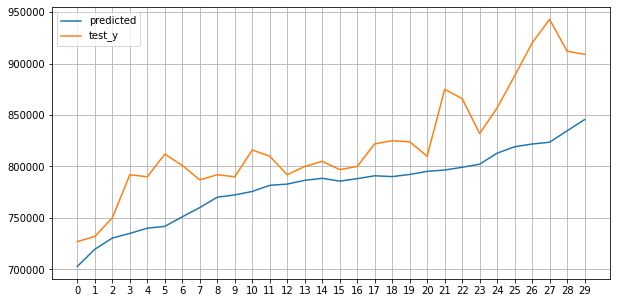

In [101]:
predicted_y = predicted.cpu().numpy()
test_y = testY_tensor.numpy()
test_x = test[7:,2]
calculated_predicted_y = ((predicted_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_y = ((test_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_x = test_x.astype('int')

show_train_status()
eval_open_to_predict_close(day)
eval_endPredict_to_predict_close(day)
show_test_graph(day)

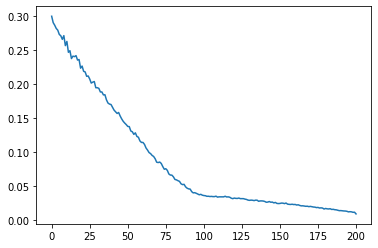

Net(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
----------------------
batch_size :  2048
epoch :  200
----------------------
시가->예측종가기준
벌어들인돈 : 0원
정확도 : 0.367%
----------------------
전날예측종가->예측종가
벌어들인돈 : 187000원
정확도 : 0.552%


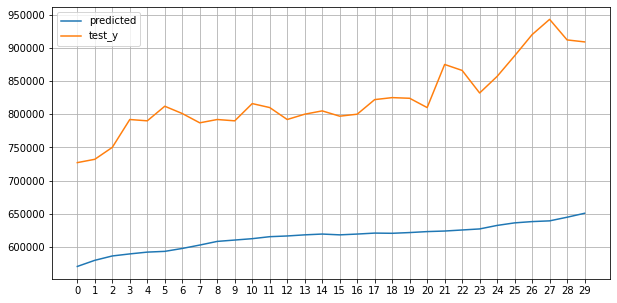

In [105]:
predicted_y = predicted.cpu().numpy()
test_y = testY_tensor.numpy()
test_x = test[7:,2]
calculated_predicted_y = ((predicted_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_y = ((test_y * (test_denom[0] + 1e-7)) + test_min[0]).astype('int')
calculated_test_x = test_x.astype('int')

show_train_status()
eval_open_to_predict_close(day)
eval_endPredict_to_predict_close(day)
show_test_graph(day)